In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

from sklearn import metrics

In [2]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

In [4]:
from helpers import clean_data, group_data, prep_ML, normalize
dfc = clean_data(df)
dfg = group_data(dfc)
X_p,y_possible = prep_ML(dfg)
X = normalize(X_p, None)
# We use our best version of the previous part.
label_true = ((y_possible['rater1'] + y_possible['rater2']) / 2 <= 0.5).values

First let's try the k-means algorithm with 2 clusters and print out the silhouette score:

In [5]:
from sklearn.cluster import KMeans

FYI: n_jobs = 1 because the parallel version of k-means doesn't work on OSX.

In [6]:
km = KMeans(n_clusters=2, max_iter=600, init="k-means++", n_jobs=1 )

In [7]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
labels = km.labels_
s1 = metrics.silhouette_score(X, labels, metric='euclidean')
print("s1 =", s1)

s1 = 0.520182286269


In [9]:
def test_km(X):
    km = KMeans(n_clusters=2, max_iter=600, init="k-means++", n_jobs=1 )
    km.fit(X)
    labels = km.labels_
    return metrics.silhouette_score(X, labels, metric='euclidean')

We know that the most valuable feature is the mean_Exp therefore we will remove it (just for fun)

In [10]:
from helpers import compute_feature_importance_rfc

compute_feature_importance_rfc(X, label_true)

[('club', 0.053062459876586664),
 ('defeats', 0.048939337582832476),
 ('redCards', 0.032354111400858879),
 ('leagueCountry', 0.025911223899151875),
 ('goals', 0.068225441482485771),
 ('weight', 0.047933455223647295),
 ('seIAT', 0.10406807646759383),
 ('yellowCards', 0.05451039899203549),
 ('victories', 0.075867516779471608),
 ('yellowReds', 0.025278663822057089),
 ('ties', 0.048283262037958581),
 ('position', 0.037545228600679728),
 ('games', 0.053245176515654608),
 ('height', 0.058549133898307029),
 ('meanExp', 0.11160881612815028),
 ('meanIAT', 0.079520768198378874),
 ('seExp', 0.075096929094149889)]

In [11]:
X2 = X.drop("meanExp", axis=1)
s2 = test_km(X2)
print("s2 =", s2)
print("s2 - s1 =", s2 - s1)

s2 = 0.520182515253
s2 - s1 = 2.28984719408e-07


We have a better result... that's fun !

Ok now let's remove a second feature, we will follow the same intuition as before and remove the second best feature, the club information.

In [12]:
# we know from before that the mean_Exp and goal information is at position 8, and 7 respectively in the X array
X3 = X.drop(["meanExp", "goals"], axis=1)
s3 = test_km(X3)
print("s3 =", s3)
print("s3 - s1 =", s3 - s1)
print("s3 - s2 =", s3 - s2)

s3 = 0.534763979031
s3 - s1 = 0.0145816927624
s3 - s2 = 0.0145814637777


There is an even better improvement

In [13]:
# we now remove seExp in addition to the other 2 (3rd best feature)
X4 = X.drop(["meanExp", "goals", "seIAT"], axis=1)
s4 = test_km(X4)
print("s4 =", s4)
print("s4 - s1 =", s4 - s1)
print("s4 - s2 =", s4 - s2)
print("s4 - s3 =", s4 - s3)

s4 = 0.534763979043
s4 - s1 = 0.0145816927747
s4 - s2 = 0.0145814637899
s4 - s3 = 1.2266077043e-11


To see whether the clustering is close to a dark/light separation we will compute in addition to the silhouette the adjusted mutual info score 

In [14]:
def scoring_complete(X):
    km = KMeans(n_clusters=2, max_iter=300, init="k-means++", n_jobs=1 )
    km.fit(X)
    labels = km.labels_
    print("silhouette score :", metrics.silhouette_score(X, labels, metric='euclidean'))
    print("closeness to true label score :", metrics.adjusted_mutual_info_score(label_true, labels))

scoring_complete(X)

silhouette score : 0.520182286269
closeness to true label score : 0.00148503518648


We have a very low closeness score but at least it's positive.

In [15]:
scoring_complete(X2)

silhouette score : 0.520182515253
closeness to true label score : 0.00148503518648


Here we see that eventhough the silhouette score is better our label accuracy is the same as before.

Other example :

In [16]:
scoring_complete(X3)

silhouette score : 0.534763979031
closeness to true label score : 0.00139343315139


In [17]:
scoring_complete(X4)

silhouette score : 0.534763979043
closeness to true label score : 0.00139343315139


Clearly here we are changinging the biais of the clustering algorithm (with respect to our "true" labels) **TODO : verify this !**

Now let's remove the worse features for example the red / yellow / redYellow / cards (not all are the absolute worst but they were all in the < 0.05 importance in the previous exercice.)

rows : 8, 10, 11

In [18]:
X5 =  X.drop(["yellowReds", "redCards", "yellowCards"], axis=1)
scoring_complete(X5)

silhouette score : 0.525815015218
closeness to true label score : 0.00153154185275


We have good results ! the silhouette is good and closeness has improved.

Let's now remove all the features that have the worst feature importance until our closeness score drops significantly

In [19]:
compute_feature_importance_rfc(X5, label_true)

[('club', 0.066566347259846961),
 ('defeats', 0.059412204438561468),
 ('leagueCountry', 0.027839715349370967),
 ('goals', 0.074112114751412286),
 ('weight', 0.054574239569540446),
 ('seIAT', 0.12638787860345368),
 ('victories', 0.07028670372226789),
 ('ties', 0.062611871226016635),
 ('position', 0.041695509980952832),
 ('games', 0.064834018972164023),
 ('height', 0.063417660316122393),
 ('meanExp', 0.10253957401827234),
 ('meanIAT', 0.095063144469001937),
 ('seExp', 0.090659017323016206)]

In [20]:
X6 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height"], axis=1)
scoring_complete(X6)

silhouette score : 0.527552347322
closeness to true label score : 0.00153154185275


In [21]:
compute_feature_importance_rfc(X6, label_true)

[('club', 0.08203161710512949),
 ('defeats', 0.064251156414856653),
 ('goals', 0.089930430693240138),
 ('weight', 0.0603671930709564),
 ('seIAT', 0.14237607590374385),
 ('victories', 0.091104415326914531),
 ('ties', 0.060434512453772113),
 ('games', 0.06509777718392884),
 ('meanExp', 0.12408516536910708),
 ('meanIAT', 0.11619993471884195),
 ('seExp', 0.104121721759509)]

In [22]:
X7 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height", "weight"], axis=1)
scoring_complete(X7)

silhouette score : 0.529022900697
closeness to true label score : 0.00153154185275


In [23]:
compute_feature_importance_rfc(X7, label_true)

[('club', 0.082188712921463486),
 ('defeats', 0.077387879181286284),
 ('goals', 0.095575701445632322),
 ('seIAT', 0.14923040580225896),
 ('victories', 0.089680800582453202),
 ('ties', 0.073753255345470628),
 ('games', 0.067271726229708451),
 ('meanExp', 0.13740982887247086),
 ('meanIAT', 0.12319791325376517),
 ('seExp', 0.10430377636549067)]

In [24]:
X8 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height", "weight", "defeats"], axis=1)
scoring_complete(X8)

silhouette score : 0.536964515555
closeness to true label score : 0.00167489477223


In [25]:
compute_feature_importance_rfc(X8, label_true)

[('club', 0.078391744088003312),
 ('goals', 0.094459459758555561),
 ('seIAT', 0.14523494314975763),
 ('victories', 0.093691704126949091),
 ('ties', 0.094611472119133844),
 ('games', 0.094314106792349001),
 ('meanExp', 0.14166005008247839),
 ('meanIAT', 0.14106578028470942),
 ('seExp', 0.11657073959806377)]

In [26]:
X9 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height", "weight", "defeats", "ties"], axis=1)
scoring_complete(X9)

silhouette score : 0.54100299212
closeness to true label score : 0.00117917185045


We stop here as we have the worst result.

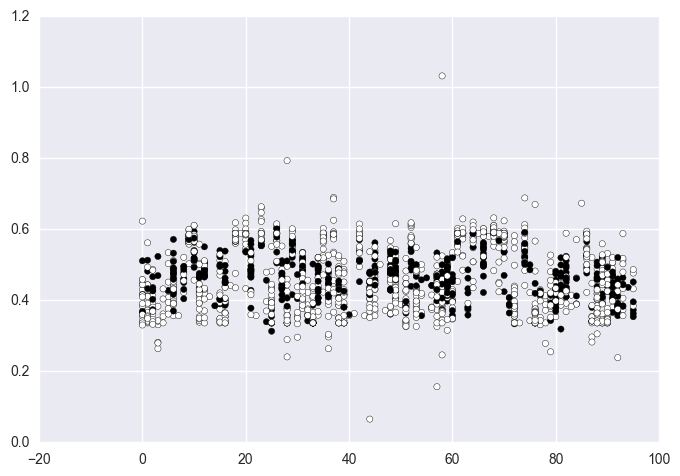

In [27]:
plt.scatter(X8["club"], X8["meanExp"], c=labels)